In [1]:
import numpy as np
from scipy.sparse import csc_matrix, lil_matrix, spdiags
from scipy.sparse.linalg import spsolve, factorized
import matplotlib.pyplot as plt
import dielectricnetworks as den

np.set_printoptions(threshold=np.inf)


In [2]:
#def convertListsToIncidenceMatrix(bondList, nodeList, sourcemask, sinkmask):
#    n = np.max(bondList) + 1
#    m = len(bondList)
#    B0 = lil_matrix((n, m))
#    for i, bond in enumerate(bondList):
#        B0[bond[0], i] = -1.0
#        B0[bond[1], i] = 1.0
#    #tokeep = np.invert(sinkmask)
#    B = B0#[tokeep, :]
#    return csc_matrix(B), np.shape(B)[0], m
#
#def generateInputCurrentVector(sourcemask, sinkmask, inputCurrent, outputCurrent):
#    d = np.zeros(len(sourcemask))
#    d[sourcemask] = inputCurrent
#    d[sinkmask] = -outputCurrent
#    return d

def convertListsToIncidenceMatrix(bondList, nodeList, sourcemask, sinkmask):
    n = np.max(bondList) + 1
    m = len(bondList)
    B0 = lil_matrix((n, m))
    for i, bond in enumerate(bondList):
        B0[bond[0], i] = -1.0
        B0[bond[1], i] = 1.0
    tokeep = np.invert(sinkmask)
    B = B0[tokeep, :]
    return csc_matrix(B), np.sum(tokeep), m

def generateInputCurrentVector(sourcemask, sinkmask, inputCurrent,outputCurrent):
    d = np.zeros(len(sourcemask))
    d[sourcemask] = inputCurrent
    return d[np.invert(sinkmask)]

def calculate_flux_per_node(n, bondList, currents):
    flux = np.zeros(np.max(bondList) + 1)
    for bond_idx, bond in enumerate(bondList):
        node1, node2 = bond
        current = currents[bond_idx]
        # TODO: why the 0.5?
        flux[node1] += 0.5 * np.abs(current)
        flux[node2] += 0.5 * np.abs(current)
    return flux

#def set_phi(v, r, V, epsilon,broken):
#    phi = epsilon * v
#    mask1 = v < (-V)
#    phi[mask1] = r * (v[mask1] + V[mask1]) - V[mask1] * epsilon[mask1]
#    mask2 = v > V
#    phi[mask2] = r * (v[mask2] - V[mask2]) + V[mask2] * epsilon[mask2]
#    broken[mask1] = 1
#    broken[mask2] = 1
#    #phi[broken] = r*v[broken]
#    return phi,broken

def set_phi(v, r, V, epsilon,broken):
    phi = epsilon * v
    mask1 = v < (-V)
    phi[mask1] = r * (v[mask1] + V[mask1]) - V[mask1] * epsilon[mask1]
    mask2 = v > V
    phi[mask2] = r * (v[mask2] - V[mask2]) + V[mask2] * epsilon[mask2]
    broken_new = np.copy(broken)
    broken_new[mask1] = 1
    broken_new[mask2] = 1
    phi[broken] = r*v[broken]
    return phi,broken_new


def solve_vdot(factor, B, phi, d):
    temp3 = B.dot(phi) - d
    return factor(-temp3)



In [3]:
L = 50
W = 50
C0 = 1		# Edge capacitance
r = 800		# plasma conductivity
delta = 0.7  # dielectric rigidity = {0.3550, 0.4375, 0.5200, 0.6025, 0.7000, 0.7675}
I = 100#10#300.0  		# Current, assumed to be unity but not stated in article
T = 0.001
Vscale = 1.0

# Input for dynamic solver
t_begin = 0.0
dt = 0.001  	# not stated in article
t_end = 3500  	# not stated in article
Nstep = int(50/dt)

np.random.seed(0)

#bond_list, node_list, sourcemask, sinkmask = den.triangular_lattice_line_line(2*L+1,2*W+1) 
bond_list, node_list, sourcemask, sinkmask = den.triangular_lattice_point_line(2*L+1,2*W+1) 

B, n, m = convertListsToIncidenceMatrix(bond_list, node_list, sourcemask, sinkmask)
Nsource = np.sum(sourcemask)
Nsink = np.sum(sinkmask)

# TODO: not dividing input current by number of input nodes (because I am looking at singular source and singular sink).
#d = generateInputCurrentVector(sourcemask, sinkmask, I/Nsource, I/Nsink)   
d = generateInputCurrentVector(sourcemask, sinkmask, 0, 0)   
epsilon = 1e-5 * np.ones(m)  # Conductivity below threshold



Simulation started


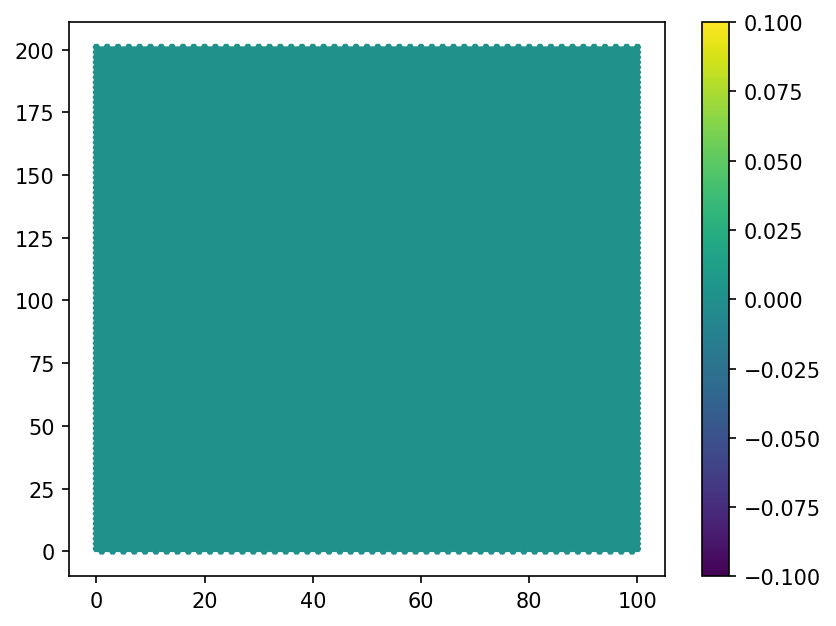

0.00000


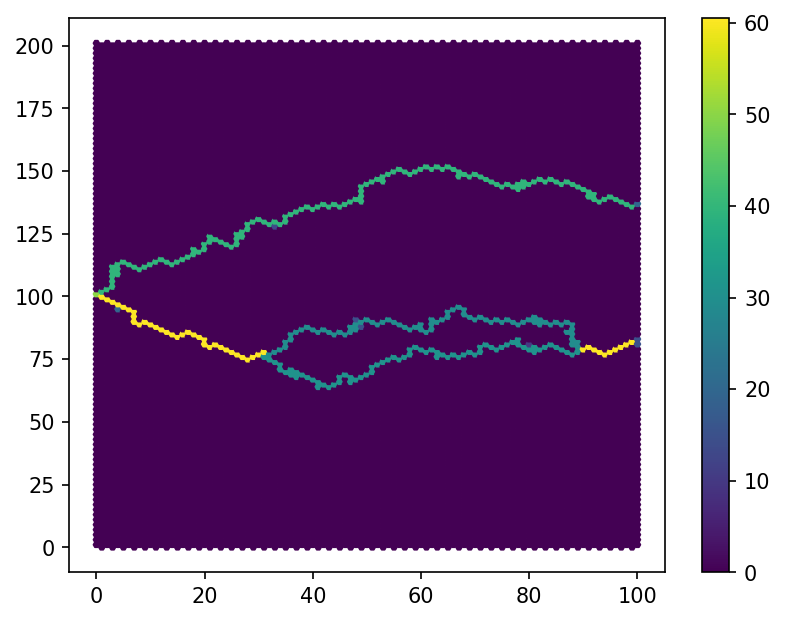

50.00000


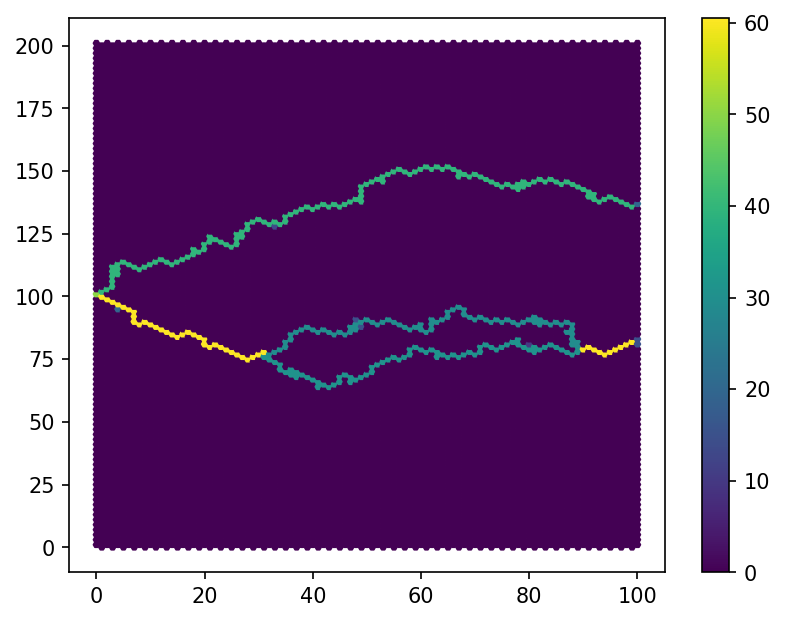

100.00000


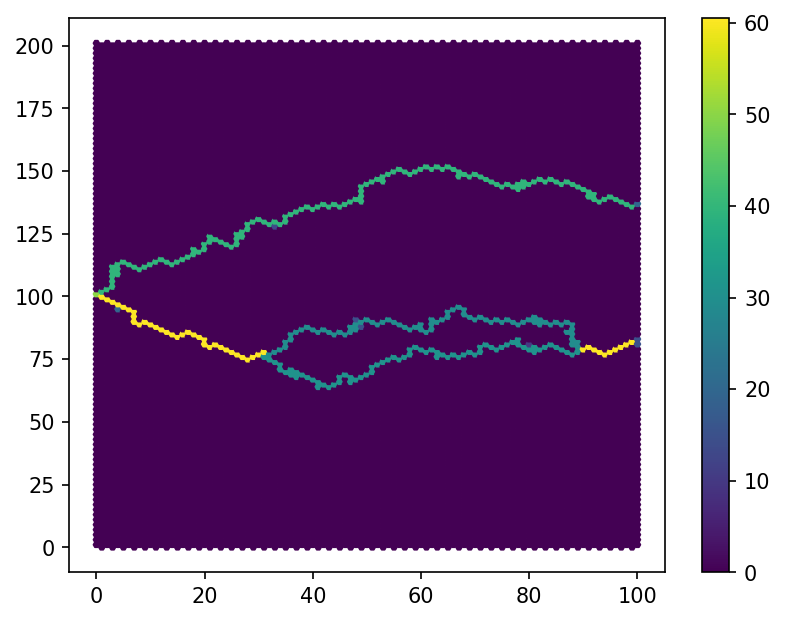

150.00000


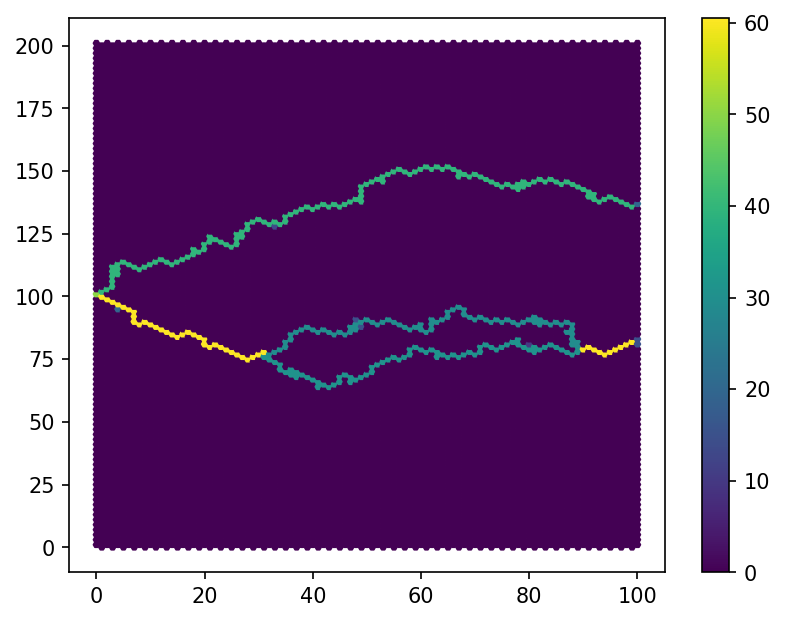

200.00000


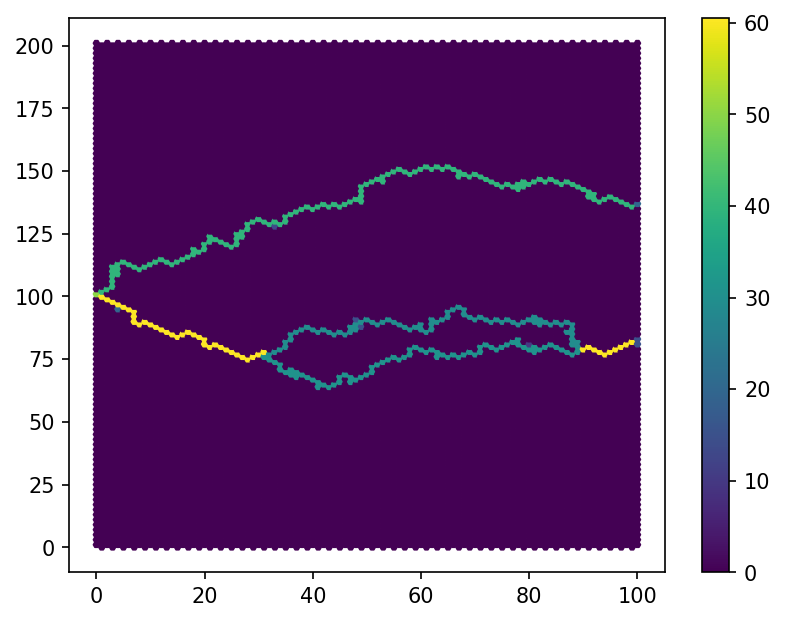

250.00000


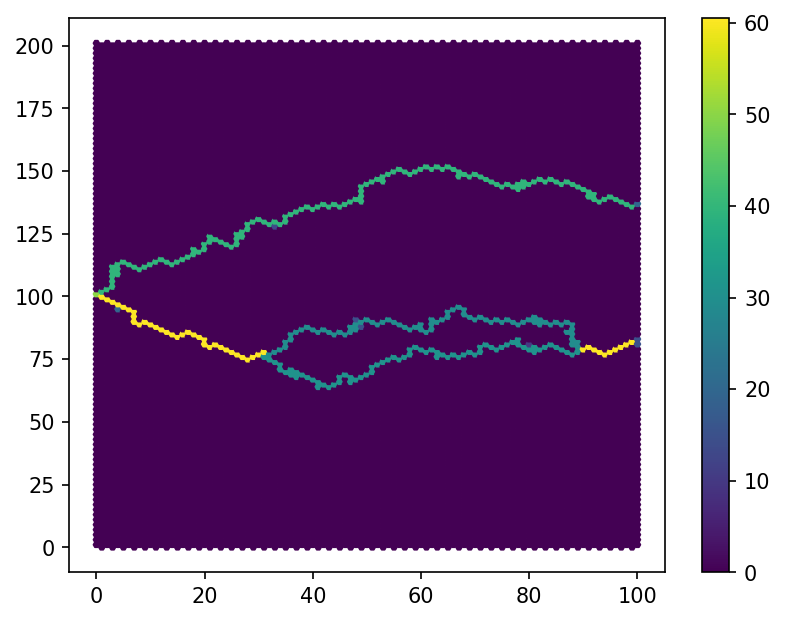

300.00000


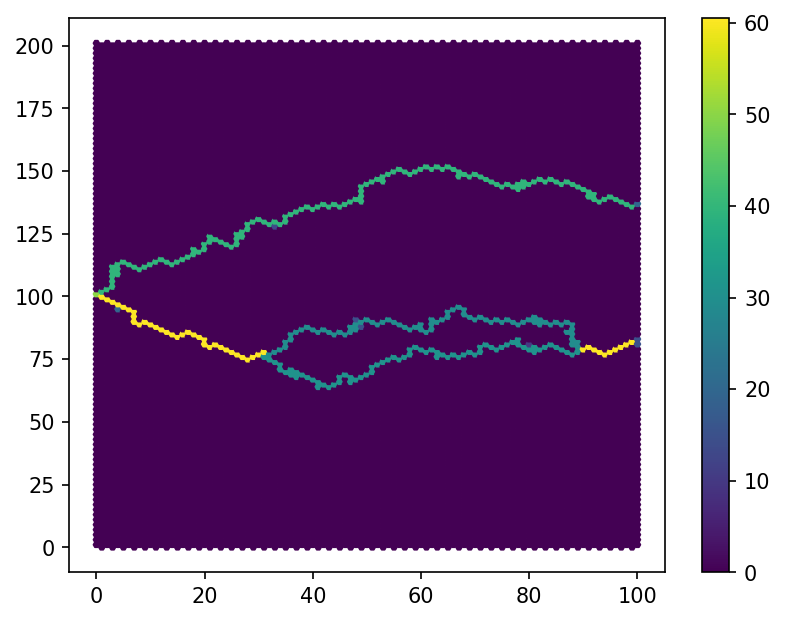

350.00000


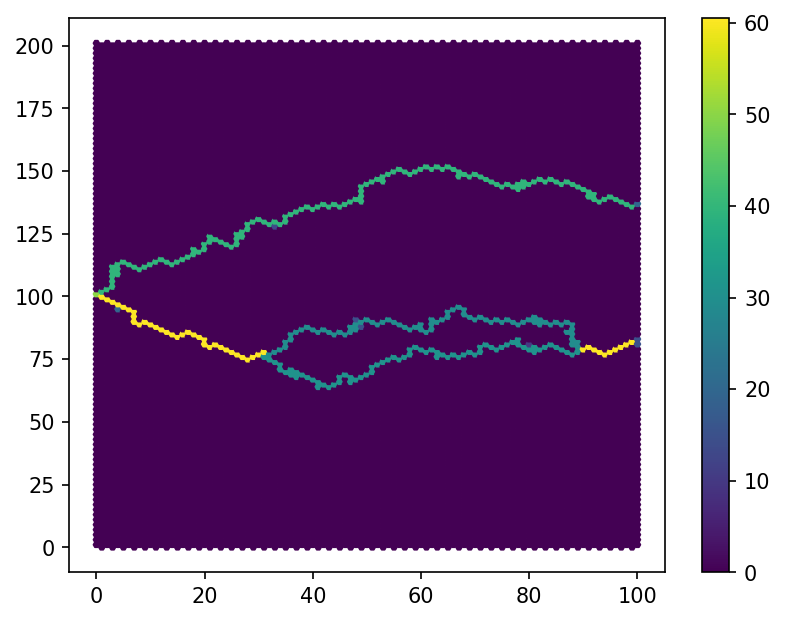

400.00000


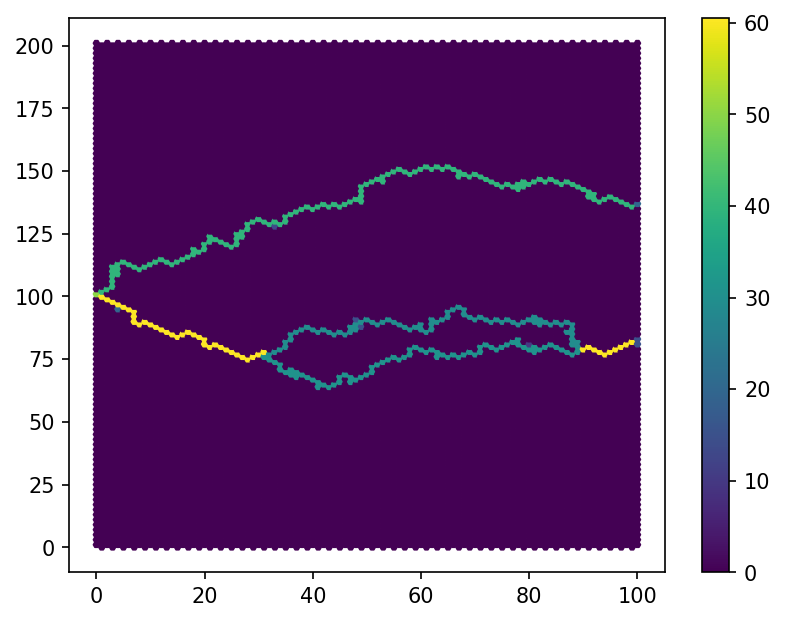

450.00000


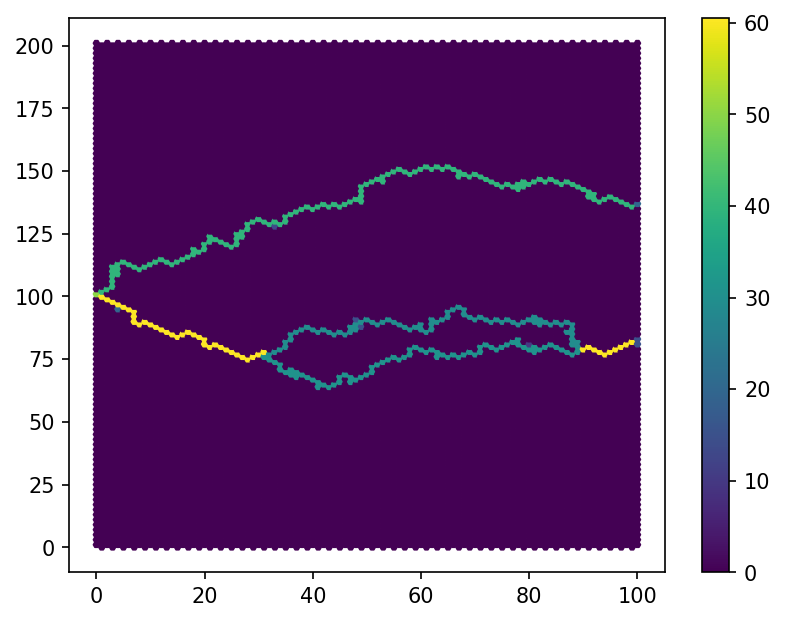

500.00000


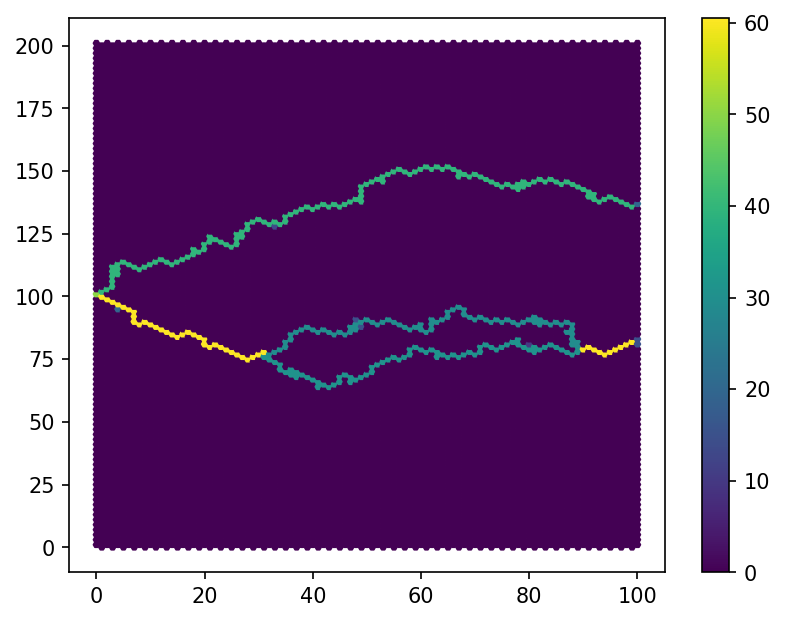

550.00000


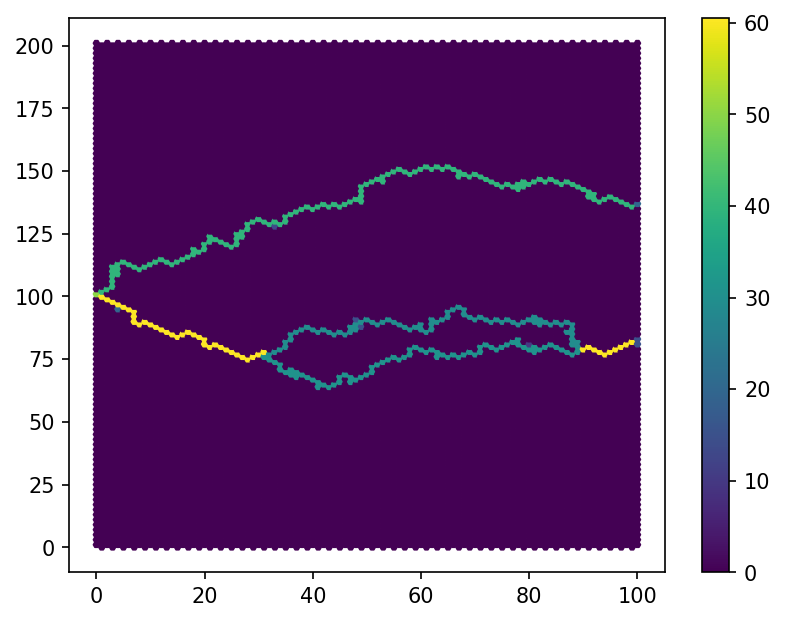

600.00000


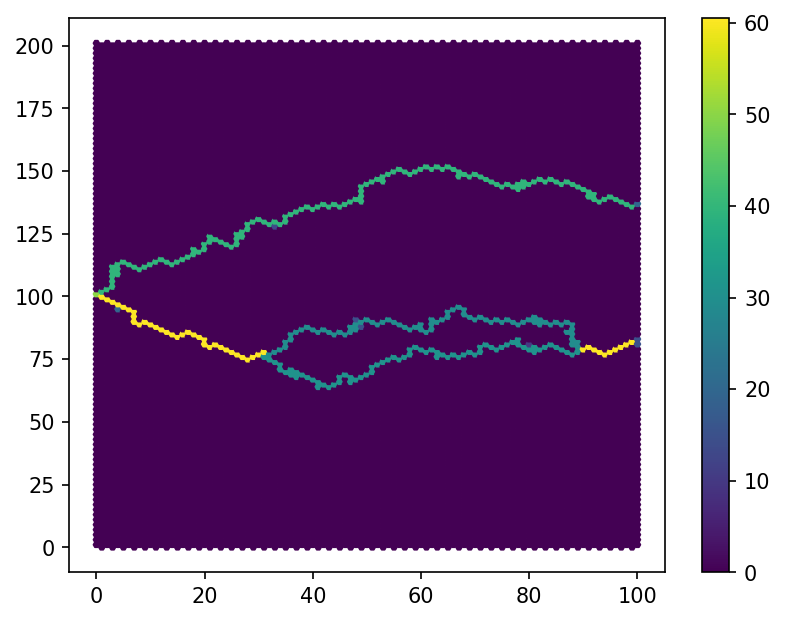

650.00000


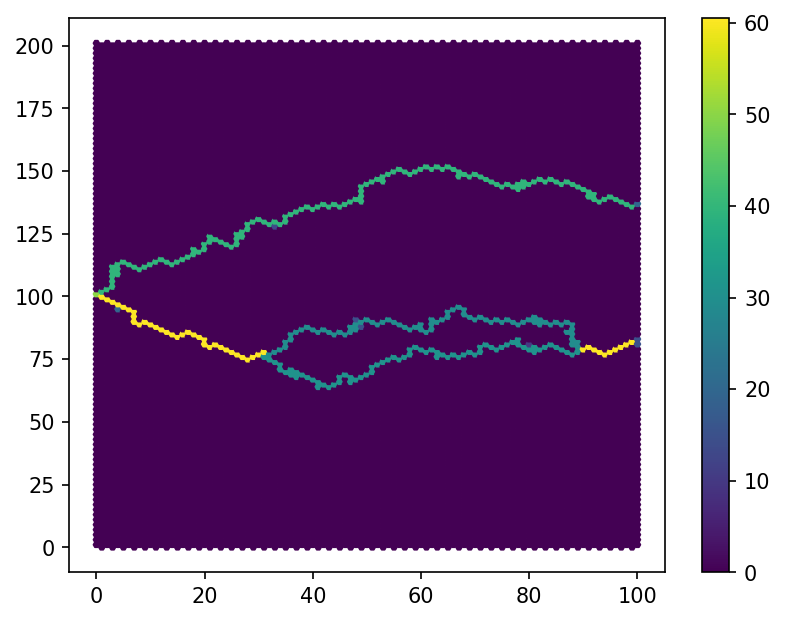

700.00000


KeyboardInterrupt: 

In [4]:
v = np.zeros(n)  # potentials at nodes
vdot = np.zeros(n)  # potential change at nodes

i = np.zeros(m)  # currents at edges
C = spdiags(C0 * np.ones(m), 0, m, m, format="csc")  # Capacitance at edges
V = Vscale*np.random.uniform(low=0.5 - delta / 2, high=0.5 + delta / 2, size=m)
broken = np.zeros(len(V)).astype(bool)
Nsave = np.floor(t_end / dt / Nstep).astype(int) + 1
fluxgrid_array = np.zeros([Nsave, 2 * L + 1, 2 * W + 1])

Bt = B.transpose()
temp0 = B @ C
temp1 = temp0 @ Bt
CatBt = C @ Bt

# Convert matrices that will used for dot product to csr, which is more efficient
B = B.tocsr()
Bt = Bt.tocsr()
CatBt = CatBt.tocsr()

# Pre-factorizing of the [BCB^T] to prepare for LU decomposition
factor = factorized(temp1)

t = 0
step = 0
save_count = 0
v0 = np.copy(v)

dv = Bt.dot(v)  # B^T v(t)

phi, broken= set_phi(dv, r, V, epsilon,broken)
vdot = solve_vdot(factor, B, phi, d)

print("\nSimulation started")
savior = []

while t < t_end:
    d = generateInputCurrentVector(sourcemask, sinkmask, I/Nsource*np.minimum(1,t/T), I/Nsink*np.minimum(1,t/T))   

    if step % Nstep == 0:
        i = phi + (CatBt).dot(vdot)
        savior.append(calculate_flux_per_node(n, bond_list, i))
        plt.figure(dpi=150)
        plt.scatter(node_list[:,0],node_list[:,1],s=6.8,c=savior[-1],marker="H")
        plt.colorbar()
        plt.show()
        print(f"{t:0.5f}")
        save_count += 1
        

    dv = Bt.dot(v)  
    phi,broken = set_phi(dv, r, V, epsilon,broken)
    vdot = solve_vdot(factor, B, phi, d)

    #ooedot = (-1000/np.copy(epsilon) * np.maximum(0,(dv)**2-V**2))
    
    v += vdot * dt
    
    t += dt
    step += 1
   

In [ ]:
plt.figure(dpi=300)
plt.scatter(node_list[:,0],node_list[:,1],s=6,c=calculate_flux_per_node(n, bond_list, broken),marker="H")
plt.colorbar()

In [ ]:
#print(epsilon)
idx_max = np.argmax(np.abs(epsilon))
eps_max = np.amax(np.abs(epsilon))
print(idx_max)
print(eps_max)

plt.figure()
#plt.scatter(node_list[:,0],node_list[:,1],s=3,vmin=0,vmax=1,c=calculate_flux_per_node(n, bond_list, epsilon),marker="H")
#plt.colorbar()
plt.plot(epsilon)
plt.show()

def set_phi_test(v, r, V, epsilon):
    phi = epsilon * v
    mask1 = v < (-V)
    phi[mask1] = r * (v[mask1] + V) - V* epsilon
    mask2 = v > V
    phi[mask2] = r * (v[mask2] - V) + V * epsilon
    return phi

test_idx = idx_max-0
vrange = np.linspace(-2*V[test_idx],2*V[test_idx],100)
plt.figure()
plt.plot(vrange,set_phi_test(vrange,r,V[test_idx],epsilon[test_idx]))#epsilon[test_idx]))
plt.show()


In [ ]:
import os
frames_dir = "f-8-2-24-a5"
os.makedirs(frames_dir, exist_ok=True)

for i,flux in enumerate(savior):
    #print(i,flux.shape)
    plt.figure()
    #plt.scatter(node_list[:,0],node_list[:,1],s=30,vmin=0,vmax=1,c=flux,marker="H")
    plt.scatter(node_list[:,1],node_list[:,0],s=7,c=flux,marker="H",vmin=0,vmax=0.5)
    plt.colorbar()
    plt.savefig(os.path.join(frames_dir, f"frame_{i:03d}.png"))
    plt.close()

In [ ]:
import imageio
import numpy as np
import os

num_frames = len(savior)

# Explicitly specify the format as 'mp4'
with imageio.get_writer(frames_dir + '.mp4', fps=50, format='FFMPEG') as writer:
    for i in range(num_frames):
        image = imageio.imread(os.path.join(frames_dir, f"frame_{i:03d}.png"))
        writer.append_data(image)

print("MP4 creation complete.")